# Previsão de vendas - lojas Rossmann - Competição Kaggle

Este notebook é baseado na solução indicada pela equipe que ficou em terceiro lugar na
Competição Kaggle - Lojas Rossmann feita em 2015 com premiação de US$ 35 mil:
- Kaggle: https://www.kaggle.com/c/rossmann-store-sales/data

Os autores utilizaram Embedding de entidades e fizeram sua solução utilizando o Keras.

Eles compararam a solução deles com as outras e emitiram a seguinte opinião:
https://www.kaggle.com/c/rossmann-store-sales/discussion/17974

Eles escreveram o seguinte artigo que faz uma comparação de várias soluções, utilizando:
 - Random Forest, 
 - KNN,
 - Gradiente boosting; e 
 - Redes Neurais:

- [Cheng Guo, Felix Berkhahn, Entity Embeddings of Categorical Variables, arxiv 2016](https://arxiv.org/abs/1604.06737)

A implementação a seguir é baseada no artigo e na solução deles publicada no github, porém aqui
reescrito em PyTorch:
 - https://github.com/entron/entity-embedding-rossmann

## Importação dos pacotes

In [35]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import os, sys
np.random.seed(42)

import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from torch.autograd import Variable

import lib.pytorch_trainer as ptt

use_gpu = torch.cuda.is_available()
print('GPU available:', use_gpu)

GPU available: False


## Leitura dos arquivos csv

In [36]:
datapath = '../../datasets/'
train_data_file = datapath + "rossmann_train.csv"
store_states_file = datapath + 'rossmann_store_states.csv'

In [37]:
train_csv = pd.read_csv(train_data_file)
train_csv.head()

/Applications/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [38]:
states_csv = pd.read_csv(store_states_file).set_index(['Store'])
store_states = states_csv.as_matrix()
states_csv.head()

,State
Store,
1,HE
2,TH
3,NW
4,BE
5,SN


## Preparando as features

Foram utilizadas as seguintes propriedades:
- loja
- dia da semana
- houve ou não promoção
- ano
- mês do ano
- dia do mês
- Estado em que a loja se encontra

O alvo é a predição:
- valor das vendas no dia


In [39]:
train_csv_array = train_csv.as_matrix()
print(train_csv_array.shape)
print(train_csv_array[:5])
open_i = (train_csv_array[:,5]==1) & (train_csv_array[:,3] > 0)

train_open = train_csv_array[open_i]
n_samples = train_open.shape[0]
print(n_samples)
dt = np.array(train_open[:,2].astype('datetime64[D]'))
day = dt - dt.astype('datetime64[M]')
month = dt.astype('datetime64[M]').astype(np.int) % 12
year = dt.astype('datetime64[Y]').astype(int) + 1970

train_Xnew = np.empty((n_samples,7),dtype=np.int)
store_index = train_csv_array[open_i,0].astype(np.int) # store_index
train_Xnew[:,0] = store_index
train_Xnew[:,1] = train_csv_array[open_i,1] # day_of_week
train_Xnew[:,2] = train_csv_array[open_i,6] # promo
train_Xnew[:,3] = year # year
train_Xnew[:,4] = month # month
train_Xnew[:,5] = day # day
for i in np.arange(n_samples):
    train_Xnew[i,6] = id(sys.intern(store_states[store_index[i] - 1,0])) # coloca string do Estado com número único

train_data_y = train_csv_array[open_i,3:4].astype(np.int) # Sales

print(train_Xnew.min(axis=0))
print(train_Xnew.max(axis=0))

(1017209, 9)
[[1 5 '2015-07-31' 5263 555 1 1 '0' 1]
 [2 5 '2015-07-31' 6064 625 1 1 '0' 1]
 [3 5 '2015-07-31' 8314 821 1 1 '0' 1]
 [4 5 '2015-07-31' 13995 1498 1 1 '0' 1]
 [5 5 '2015-07-31' 4822 559 1 1 '0' 1]]
844338
[         1          1          0       2013          0          0
 4637979232]
[      1115          7          1       2015         11         30
 4901624384]


### Normalização dos atributos categóricos

Utiliza-se aqui a mesma função `np.unique` utilizada na normalização dos índices dos
títulos de filmes do notebook movielens.

In [40]:
X_norm = np.empty_like(train_Xnew)
for i in range(X_norm.shape[1]): # para cada coluna (atributo)
    classes, i_norm = np.unique(train_Xnew[:,i], return_inverse=True)
    X_norm[:,i] = i_norm

In [41]:
print(X_norm.min(axis=0))
print(X_norm.max(axis=0))

[0 0 0 0 0 0 0]
[1114    6    1    2   11   30   11]


In [42]:
train_data_X = X_norm
train_data_y = np.array(train_data_y)
(X, y) = (train_data_X, train_data_y)
print(X.min(axis=0))
print(X.max(axis=0))
print(y.min(axis=0))
print(y.max(axis=0))

[0 0 0 0 0 0 0]
[1114    6    1    2   11   30   11]
[46]
[41551]


## Visualizando em boxplot

- [0] dia da semana (0 a 6)
- [1] houve ou não promoção (0 ou 1)
- [2] ano (0, 1 ou 2)
- [3] mês do ano (0 a 11)
- [4] dia do mês (0 a 30)
- [5] Estado em que a loja se encontra (0 a 11)


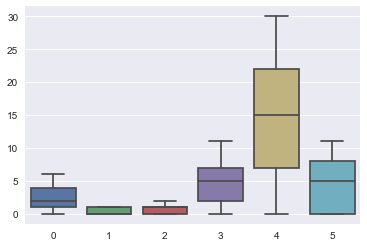

In [43]:
import seaborn as sns
sns.boxplot(data=X[:,1:])

## Normalizando os valores de vendas

$$ Sales_n = \frac{\log{(Sales)}}{Max(\log(Sales))} $$
$$ Sales = \exp(Sales_n Max(\log(Sales))) $$

In [44]:
class log_norm():
    def __init__(self,y):
        self.MaxLog = np.log(y).max()
        
    def lognorm(self, val):
        return np.log(val)/self.MaxLog
    
    def lognorm_back(self, val):
        return np.exp(val * self.MaxLog)

classnorm = log_norm(y)
y_norm = classnorm.lognorm(y)
y_back = classnorm.lognorm_back(y_norm)


In [49]:
np.isclose(y_back, y).all()

True

## Dividindo em Dados de treinamento e de validação

In [48]:
num_records = len(X)
train_ratio = 0.9
train_size = int(train_ratio * num_records)

X_train = X[:train_size]
X_val   = X[train_size:]
y_train = y_norm[:train_size]
y_val   = y_norm[train_size:]
y_orig_val = y[train_size:]
print('Shapes:',X_train.shape,y_train.shape,X_val.shape,y_val.shape)
print('X_train[:2]\n',X_train[:2])
print('y_train[:2]\n',y_train[:2])

Shapes: (759904, 7) (759904, 1) (84434, 7) (84434, 1)
X_train[:2]
 [[ 0  4  1  2  6 30  8]
 [ 1  4  1  2  6 30  1]]
y_train[:2]
 [[ 0.80570915]
 [ 0.81903052]]


In [12]:
def sample(X, y, n):
    '''random samples'''
    num_row = X.shape[0]
    indices = np.random.randint(num_row, size=n)
    return X[indices, :], y[indices]

X_train, y_train = sample(X_train, y_train, 200000)  # Simulate data sparsity
print("Number of samples used for training: ",y_train.shape[0])

Number of samples used for training:  200000


## Convertendo para PyTorch

In [13]:
X_train_t = torch.LongTensor(X_train.astype(np.int))
y_train_t = torch.FloatTensor(y_train) 
X_val_t   = torch.LongTensor(X_val.astype(np.int))
y_val_t   = torch.FloatTensor(y_val) 

In [14]:
X_train_t.shape, X_train_t.type(), X_val_t.shape, X_val_t.type()

(torch.Size([200000, 7]),
 'torch.LongTensor',
 torch.Size([84434, 7]),
 'torch.LongTensor')

In [15]:
y_train_t.shape, y_train_t.type() ,y_val_t.shape, y_val_t.type(), y_val_t.mean(), y_val_t.var()

(torch.Size([200000, 1]),
 'torch.FloatTensor',
 torch.Size([84434, 1]),
 'torch.FloatTensor',
 0.8183490718584582,
 0.001739647024687579)

## Definição da classe MLDataset

In [16]:
from torch.utils.data import Dataset
class MLDataset(Dataset):
    def __init__(self, data_in, target):
        assert data_in.size(0)  == target.size(0)
        
        self.data   = data_in
        self.target = target

    def __len__(self):
        return self.target.size(0)

    def __getitem__(self, i):
        return (self.data[i], self.target[i])
    
datasets = {
    'train': MLDataset(X_train_t, y_train_t),
    'val'  : MLDataset(X_val_t,   y_val_t)
    }

dataloaders = {
    'train': torch.utils.data.DataLoader(datasets['train'], batch_size=128, shuffle=True),
    'val'  : torch.utils.data.DataLoader(datasets['val'],   batch_size=128, shuffle=False)
    }


### Testando o Dataset

In [17]:
xx, yy = datasets['train'][3:5]
print(xx)
print(yy)


   10     0     1     1     5     1    10
 1012     5     0     1     9    10     0
[torch.LongTensor of size 2x7]


 0.8674
 0.7062
[torch.FloatTensor of size 2x1]



## Criando o modelo

### Modelo com vários embeddings


|Característica|tipo do dado|tamanho|dimensão embedding|
|--------------|------------|-------|------------------|
| store      | nominal| 1115|10|
| day of week| ordinal| 7| 6|
|promoção| binário | 2|1|
| ano| ordinal| 3 (2013-2015)|2|
| mês| ordinal| 12| 6|
| dia| ordinal| 31| 10|
| Estado|nominal| 12| 6|
 


In [18]:
class Model(nn.Module):
    def __init__(self, ):
        """
        No construtor, criamos as duas embeddings, uma para os usuários e 
        outra para os filmes.
        """
        super(Model, self).__init__()
        self.store_emb  = nn.Embedding(1115, 10)
        nn.init.xavier_uniform(self.store_emb.weight)
        
        self.dow_emb = nn.Embedding(7, 6)
        nn.init.xavier_uniform(self.dow_emb.weight)

        self.promo_linear = nn.Linear(1, 1)

        self.year_emb = nn.Embedding(3, 2)
        nn.init.xavier_uniform(self.year_emb.weight)

        self.month_emb = nn.Embedding(12, 6)
        nn.init.xavier_uniform(self.month_emb.weight)

        self.day_emb = nn.Embedding(31, 10)
        nn.init.xavier_uniform(self.day_emb.weight)

        self.state_emb = nn.Embedding(12, 6)
        nn.init.xavier_uniform(self.state_emb.weight)
        
        self.linear1 = nn.Linear(10+6+1+2+6+10+6, 1000)
        self.linear2 = nn.Linear(1000,500)
        self.linear3 = nn.Linear(500,1)

    def forward(self, x):
        store_id  = x[:,0]
        dow_id    = x[:,1]
        promo_id  = x[:,2:3].type(torch.FloatTensor) # keep 2-dimensional
        year_id   = x[:,3]
        month_id  = x[:,4]
        day_id    = x[:,5]
        state_id  = x[:,6]
        store_attr  = self.store_emb(store_id)
        dow_attr    = self.dow_emb(dow_id)
        promo_attr  = self.promo_linear(promo_id)
        year_attr   = self.year_emb(year_id)### Instanciando a rede
        month_attr  = self.month_emb(month_id)
        day_attr    = self.day_emb(day_id)
        state_attr  = self.state_emb(state_id)
        x_in = torch.cat([store_attr,dow_attr,promo_attr,year_attr,month_attr,day_attr,state_attr],dim=1)
        x = nn.functional.relu(x_in)
        x = nn.functional.relu(self.linear1(x_in))
        x = nn.functional.relu(self.linear2(x))
        y_pred = self.linear3(x)
        return nn.functional.sigmoid(y_pred)


### Instanciando a rede


In [19]:
model = Model()
if use_gpu:
    model = model.cuda()
model

Model(
  (store_emb): Embedding(1115, 10)
  (dow_emb): Embedding(7, 6)
  (promo_linear): Linear(in_features=1, out_features=1)
  (year_emb): Embedding(3, 2)
  (month_emb): Embedding(12, 6)
  (day_emb): Embedding(31, 10)
  (state_emb): Embedding(12, 6)
  (linear1): Linear(in_features=41, out_features=1000)
  (linear2): Linear(in_features=1000, out_features=500)
  (linear3): Linear(in_features=500, out_features=1)
)

## Número de parâmetros da rede

In [31]:
wn = sum([v.nelement() for _,v in model.state_dict().items()])
print('Number of parameters:', wn)

Number of parameters: 554655


## Predict 4 amostras para verificar a rede

In [21]:
xx,yy = next(iter(dataloaders['train']))
y_pred = model(Variable(xx[:4]))
print(y_pred)

Variable containing:
 0.4945
 0.4995
 0.5006
 0.5084
[torch.FloatTensor of size 4x1]



In [22]:
optimizer = torch.optim.Adam(model.parameters())
savebest  = ptt.ModelCheckpoint('../../models/rossmann_torch', reset=True, verbose=1)

trainer = ptt.DeepNetTrainer(
    model         = model, 
    criterion     = nn.L1Loss(), #nn.MSELoss(),
    optimizer     = torch.optim.Adam(model.parameters()), 
    callbacks     = [savebest, ptt.PrintCallback()]
                     )

In [23]:
flag_train = True
if flag_train:
    trainer.fit_loader(n_epochs=12, train_data=dataloaders['train'], valid_data=dataloaders['val'])
else:
    trainer.load_state(file_basename='/data/models/rossmann_torch')

Start training for 12 epochs
  1:  49.1s   T: 0.01396   V: 0.01591 best
  2:  60.9s   T: 0.00927   V: 0.01220 best
  3:  75.8s   T: 0.00842   V: 0.01177 best
  4:  70.4s   T: 0.00785   V: 0.01180 
  5:  77.6s   T: 0.00755   V: 0.01170 best
  6:  76.6s   T: 0.00732   V: 0.01195 
  7:  77.7s   T: 0.00713   V: 0.01123 best
  8:  87.2s   T: 0.00696   V: 0.01100 best
  9:  85.7s   T: 0.00680   V: 0.01120 
 10:  84.2s   T: 0.00668   V: 0.01096 best
 11:  99.5s   T: 0.00657   V: 0.01134 
 12: 103.1s   T: 0.00648   V: 0.01129 
Best model was saved at epoch 10 with loss 0.01096: ../../models/rossmann_torch
Stop training at epoch: 12/12


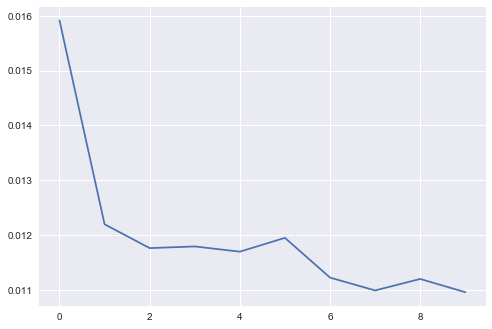

In [24]:
trainer.load_state('../../models/rossmann_torch')
plt.plot(trainer.metrics['valid']['losses'])
plt.show()

In [25]:
y_pred = trainer.predict_loader(dataloaders['val']).numpy()

## Root Mean Square Percentage Error (RMSPE)

$$ \textrm{RMSPE} = \sqrt{\frac{1}{n} \sum_{i=1}^{n} \left(\frac{y_i - \hat{y}_i}{y_i}\right)^2} $$

### Dados normalizados

In [56]:
np.sqrt(np.square((y_val - y_pred)/y_val).mean())

0.020918122475956168

### Dados originais

In [58]:
y_pred_back = classnorm.lognorm_back(y_pred)
y_val_back  = classnorm.lognorm_back(y_val)
print(np.sqrt(np.square((y_val_back - y_pred_back)/y_val_back).mean()))
print(np.sqrt(np.square((y_orig_val - y_pred_back)/y_orig_val).mean()))

0.229194365406
0.229194365406


Vencedor da competição no Kaggle obteve 0.10021 [https://www.kaggle.com/c/rossmann-store-sales/leaderboard](https://www.kaggle.com/c/rossmann-store-sales/leaderboard)

## Mean Absolute Percentage Error (MAPE)

$$ \textrm{MAPE} = \frac{1}{n} \sum_{i=1}^{n} \left|\frac{y_i - \hat{y}_i}{y_i}\right| $$

In [60]:
print(np.absolute((y_orig_val - y_pred_back)/y_orig_val).mean())

0.121254232168


In their paper, they report MAPE: 0.093